**Vehicle detector**

Importing all frameworks

In [37]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time


Image processing functions

In [38]:
def convert_color(img, conv='RGB2YCrCb'):
    """
    Converts the image color space to the given one
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if conv == 'RGB2BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

Resizing images

In [39]:
def bin_spatial(img, size=(32, 32)):
    """
    Resizes the image to the given size and returns hstack of 3 color layers
    """
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

Color histograms

In [40]:
def color_hist(img, nbins=32):
    """
    Computes the histograms of the color layers and returns concatenated ones
    """
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

Histograms of oriented gradients

In [41]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, visualize=False, feature_vector=True):
    """
    Get HOG features out of the image and visualize the output if visualize == True
    """
    
    if visualize == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vector)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vector)
        return features

Features extraction

In [42]:
def extract_features(imgs, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        
        image = cv2.imread(file)
        image = image.astype(np.float32) / 255
        
        # apply color conversion if other than 'BGR'
        if color_space != 'BGR':
            if color_space == 'HSV':
                feature_image = convert_color(image, conv='BGR2HSV')
            elif color_space == 'LUV':
                feature_image = convert_color(image, conv='BGR2LUV')
            elif color_space == 'HLS':
                feature_image = convert_color(image, conv='BGR2HLS')
            elif color_space == 'YUV':
                feature_image = convert_color(image, conv='BGR2YUV')
            elif color_space == 'YCrCb':
                feature_image = convert_color(image, conv='BGR2YCrCb')
        else: 
            feature_image = np.copy(image)
        
        """
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = convert_color(image, conv='RGB2HSV')
            elif color_space == 'LUV':
                feature_image = convert_color(image, conv='RGB2LUV')
            elif color_space == 'HLS':
                feature_image = convert_color(image, conv='RGB2HLS')
            elif color_space == 'YUV':
                feature_image = convert_color(image, conv='RGB2YUV')
            elif color_space == 'YCrCb':
                feature_image = convert_color(image, conv='RGB2YCrCb')
        else: 
            feature_image = np.copy(image)   
        """

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        visualize=False, feature_vector=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, visualize=False, feature_vector=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

Loading data

In [43]:
def read_image_names(dir_path, file_ext='png'):
    image_names = glob.glob(dir_path + '/*.' + file_ext)
    return image_names


In [44]:
# read all image names

car_image_names = []
notcar_image_names = []

car_image_names = np.concatenate((car_image_names, read_image_names('./data/vehicles/GTI_Far')))
car_image_names = np.concatenate((car_image_names, read_image_names('./data/vehicles/GTI_Left')))
car_image_names = np.concatenate((car_image_names, read_image_names('./data/vehicles/GTI_MiddleClose')))
car_image_names = np.concatenate((car_image_names, read_image_names('./data/vehicles/GTI_Right')))
car_image_names = np.concatenate((car_image_names, read_image_names('./data/vehicles/KITTI_extracted')))

notcar_image_names = np.concatenate((notcar_image_names, read_image_names('./data/non-vehicles/Extras')))
notcar_image_names = np.concatenate((notcar_image_names, read_image_names('./data/non-vehicles/GTI')))

print('Count of cars images: {}'.format(len(car_image_names)))
print('Count of not cars images: {}'.format(len(notcar_image_names)))


Count of cars images: 8792
Count of not cars images: 8968


In [45]:
color_space='YCrCb'
spatial_size=(16, 16)
hist_bins=16
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True


In [46]:
t1 = time.time()

car_features = extract_features(car_image_names, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2 - t1, 2), 'seconds to extract features for cars set...')


56.95 seconds to extract features for cars set...


In [47]:
t1 = time.time()

notcar_features = extract_features(notcar_image_names, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2 - t1, 2), 'seconds to extract features for non-cars set...')


57.08 seconds to extract features for non-cars set...


In [48]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print('X length: {}'.format(len(X)))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
print('Scaler fitted')

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print('Data transformed')

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


X length: 17760
Scaler fitted
Data transformed


In [49]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


In [50]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t1, 2), 'seconds to train SVC')


3.23 seconds to train SVC


In [51]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t1 = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2 - t1, 5), 'seconds to predict', n_predict,'labels with SVC')


Test Accuracy of SVC =  0.9921
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
0.00301 seconds to predict 10 labels with SVC


Working with the heatmaps

In [52]:
def add_heat(heatmap, bbox_list):
    """
    Increases the heat of the provided regions on the image
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    """
    Clears pixels below the threshold on the heatmap
    """
    heatmap[heatmap <= threshold] = 0

    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    """
    Draw all labeled cars boxes on the image
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

Testing the heatmap

In [53]:
"""
image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
"""


"\nimage = mpimg.imread('test_image.jpg')\nheat = np.zeros_like(image[:,:,0]).astype(np.float)\n\n# Add heat to each box in box list\nheat = add_heat(heat,box_list)\n    \n# Apply threshold to help remove false positives\nheat = apply_threshold(heat,1)\n\n# Visualize the heatmap when displaying    \nheatmap = np.clip(heat, 0, 255)\n\n# Find final boxes from heatmap using label function\nlabels = label(heatmap)\ndraw_img = draw_labeled_bboxes(np.copy(image), labels)\n\nfig = plt.figure()\nplt.subplot(121)\nplt.imshow(draw_img)\nplt.title('Car Positions')\nplt.subplot(122)\nplt.imshow(heatmap, cmap='hot')\nplt.title('Heat Map')\nfig.tight_layout()\n"

Sliding window search

In [64]:
def find_cars_boxes(img, y_start_stop, scale, svc, X_scaler, orient=9, 
              pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32,
              window=64, cells_per_step=2):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1], :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
        
    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient * cell_per_block**2
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vector=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vector=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vector=False)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            #temp_img = cv2.cvtColor(subimg, cv2.COLOR_YCrCb2RGB)
            #plt.imshow(temp_img)
            #plt.show()
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))       
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                box_list.append(((xbox_left, ytop_draw + y_start_stop[0]),
                              (xbox_left + win_draw, ytop_draw + win_draw + y_start_stop[0])))
                #cv2.rectangle(draw_img, (xbox_left, ytop_draw + y_start_stop[0]),
                #              (xbox_left + win_draw, ytop_draw + win_draw + y_start_stop[0]),
                #              (255, 0, 0), 6) 
                
    return box_list #draw_img
    

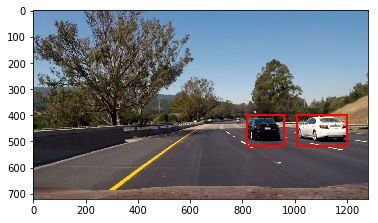

In [67]:
img = cv2.imread('./test_images/test6.jpg')

y_start_stop = [350, 656]
scale = 1.5
box_list = find_cars_boxes(img, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins, window=64, cells_per_step=2)

heat = np.zeros_like(img[:, :, 0]).astype(np.float)
heat = add_heat(heat, box_list)
heat = apply_threshold(heat, 1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

draw_img = convert_color(draw_img, conv='BGR2RGB')
plt.imshow(draw_img)
plt.show()